In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from helpers import *
from matplotlib import pyplot as plt
import numpy as np
from experiment_random import *
import pandas as pd
import seaborn as sns

Using TensorFlow backend.


Initialized TensorFlow


### Fixed single random experiment for many random points

In [2]:
# pfailure for the first layer
p = 1e-3

In [3]:
# run with random weights and multiple inputs
exp = RandomExperiment([5, 6, 7, 1], p_inference = [0, p, 0, 0], activation = 'relu', std_weight = 3, mean_weight = 0.1, do_print = True)

Creating network for 5-dimensional input and 1-dimensional output, with 2 hidden layers
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 36        
_________________________________________________________________
lambda_1 (Lambda)            (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 49        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6)                 36 

In [4]:
data_points = 100

# inputs to test
data = np.random.randn(data_points, 5) * 2

# obtaining data
rmean, rstd = exp.run(data, repetitions = 100000)

In [5]:
# printing output shapes
print_shape(rmean, 'mean')
print_shape(rstd, 'std')

=== Shapes of mean ===
           name     shape
0     sum_1norm        ()
1     sum_2norm        ()
2   sum_fronorm        ()
3   sum_infnorm        ()
4      v1_1norm    (100,)
5      v1_2norm    (100,)
6    v1_infnorm    (100,)
7            v2  (100, 1)
8            v3  (100, 1)
9            v4  (100, 1)
10   experiment  (100, 1)
=== Shapes of std ===
         name     shape
0          v2  (100, 1)
1          v3  (100, 1)
2          v4  (100, 1)
3  experiment  (100, 1)


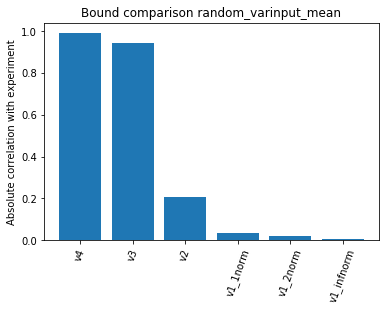

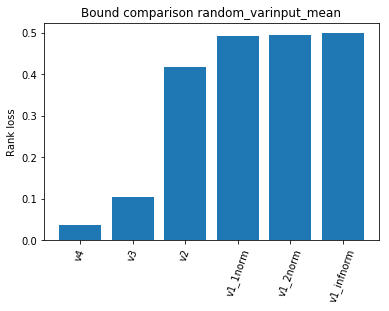

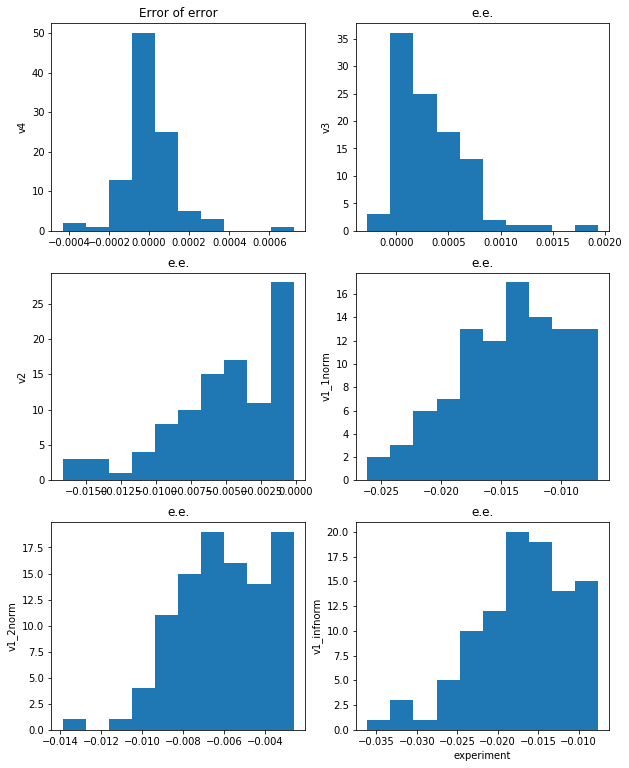

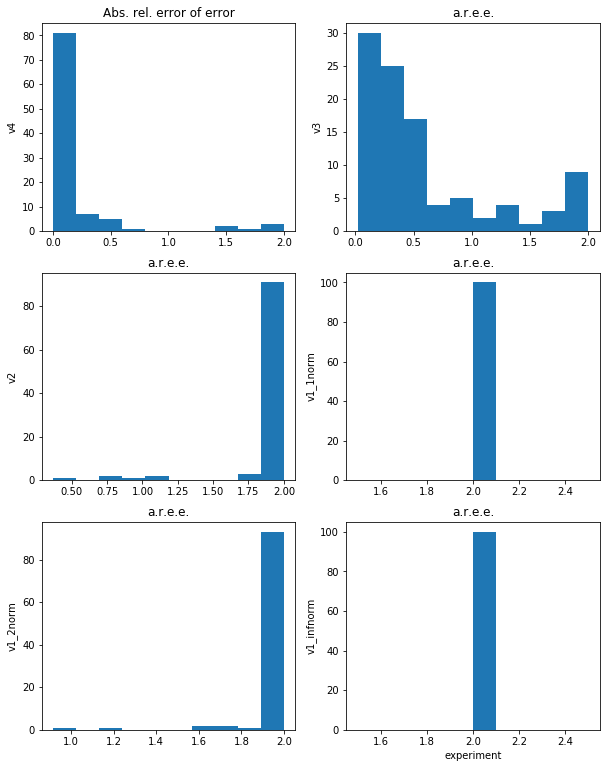

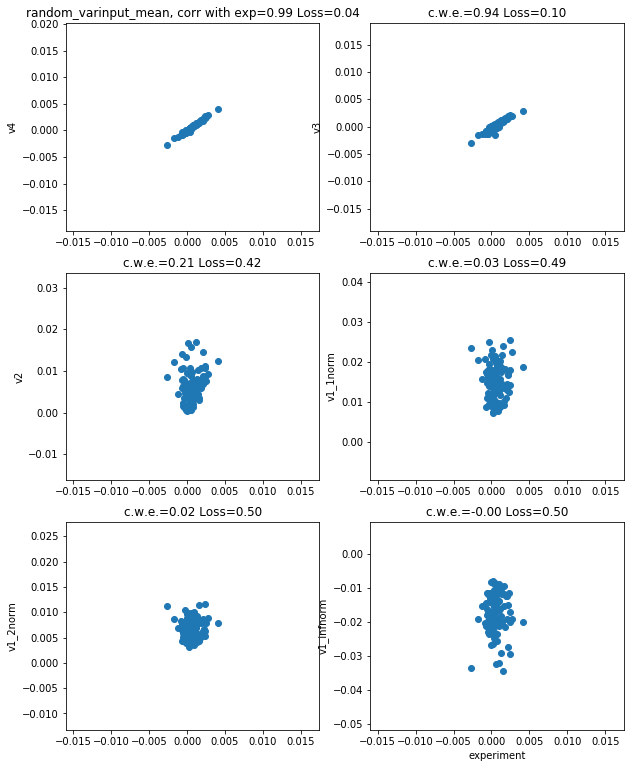

,bound,corr,rank_loss
0,v4,0.990523,0.036566
1,v3,0.941482,0.103838
2,v2,0.205261,0.416970
3,v1_1norm,0.034550,0.491717
4,v1_2norm,0.018228,0.495152
5,v1_infnorm,-0.004351,0.499394


In [13]:
exp.process_scalar_output(rmean, 'random_varinput_mean')

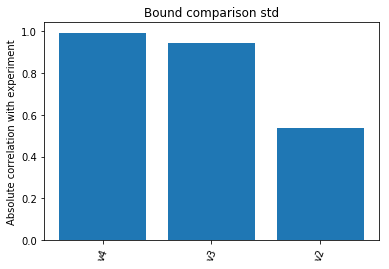

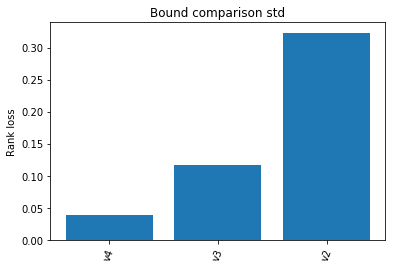

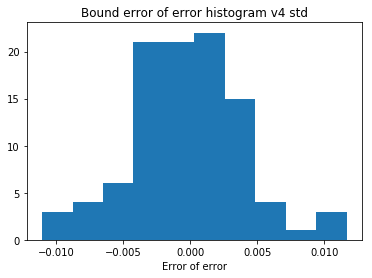

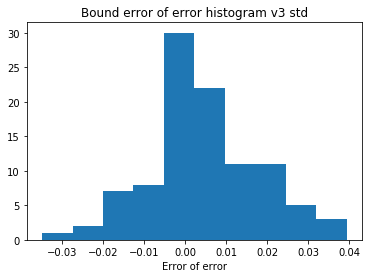

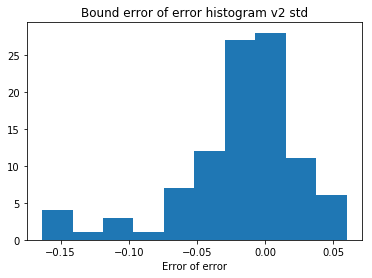

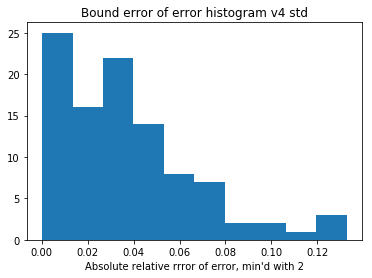

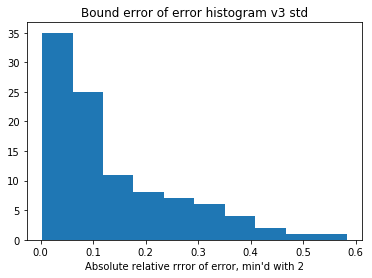

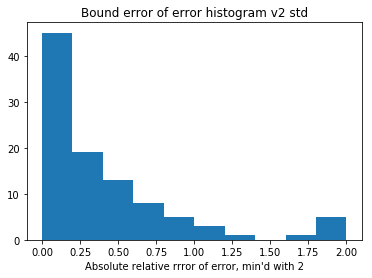

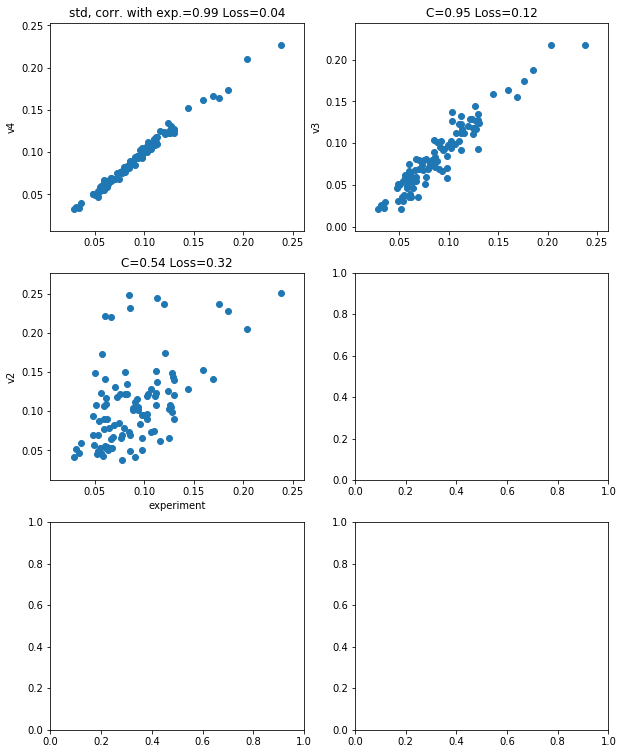

,bound,corr,rank_loss
0,v4,0.993837,0.039192
1,v3,0.947159,0.116566
2,v2,0.535105,0.323030


In [7]:
exp.process_scalar_output(rstd, 'std')

See that there's correlation of approximately 0.999... between theory (v3.exact and v3.better) and practive (experiment, mean over repetitions). Same is not true for the approximate bound which gives somethins about 0.90. Again, exact bound is better in rank loss. Squared version of the variance bound also doesn't work

### Comparing random networks on a fixed input

In [8]:
# pfailure for the first layer
p = 1e-2

# input to test
data = np.random.randn(1, 50) * 2 + 0.1

In [9]:
# array with networks
results_mean = []
results_std = []

# looking at 50 random networks
for i in tqdm(range(100)):
    # run with random weights and multiple inputs
    exp = RandomExperiment([50, 50, 50, 1], p_inference = [0, p, 0, 0], activation = 'relu', std_weight = 3, mean_weight = 0.1)

    # obtaining data
    rmean, rstd = exp.run(data, repetitions = 50000)
    
    # adding to results
    results_mean += [rmean]
    results_std += [rstd]
    
    # removing the model
    K.clear_session()

100%|██████████| 100/100 [01:20<00:00,  1.26it/s]


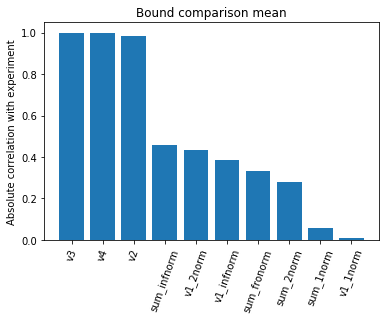

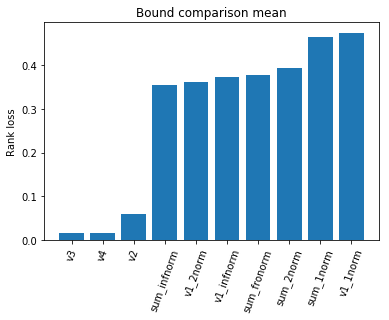

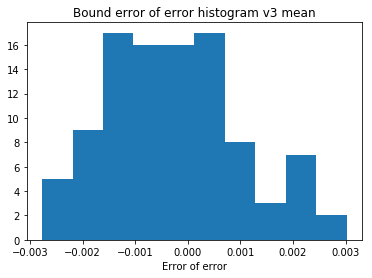

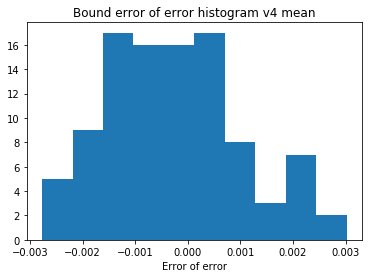

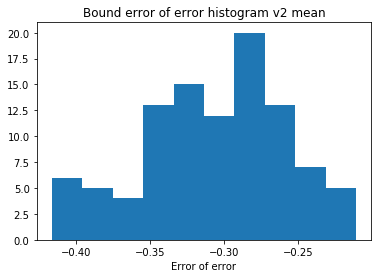

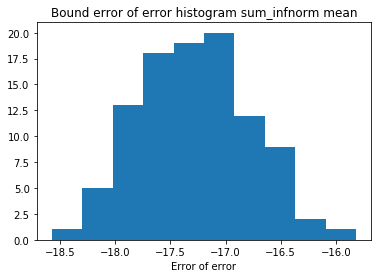

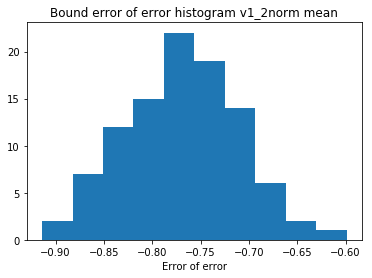

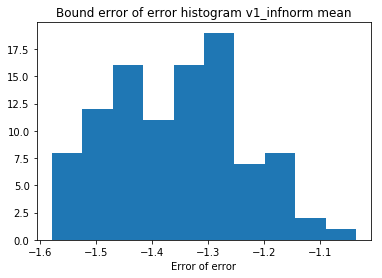

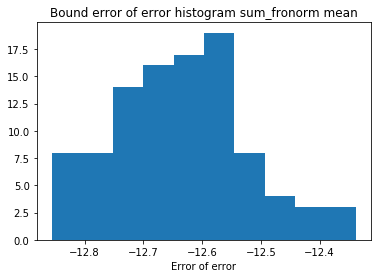

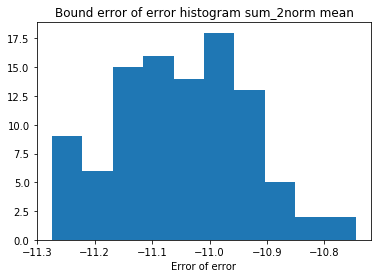

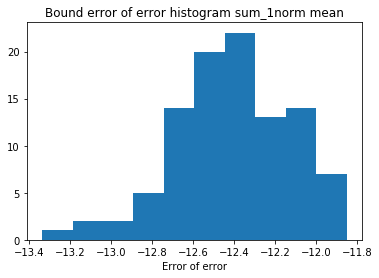

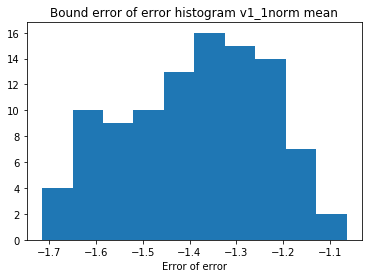

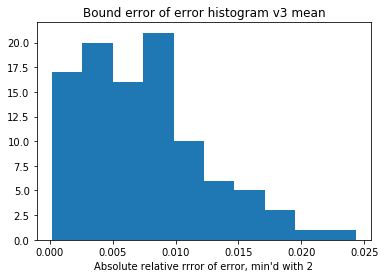

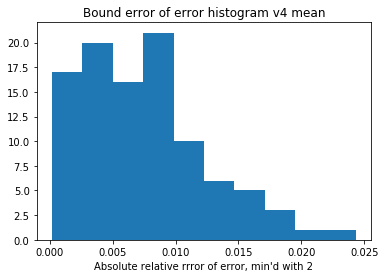

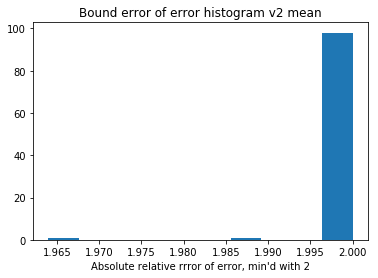

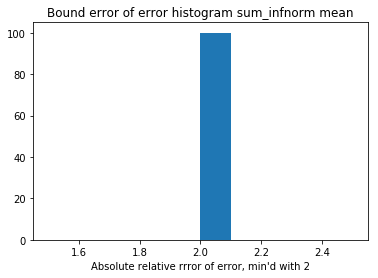

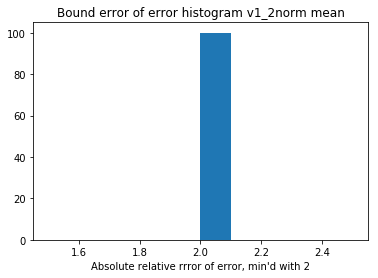

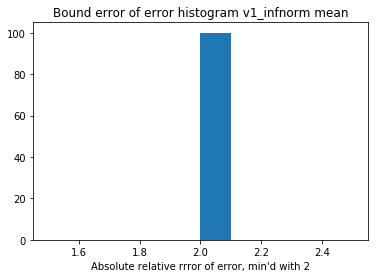

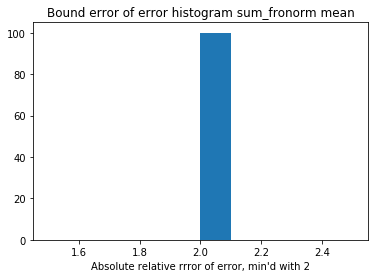

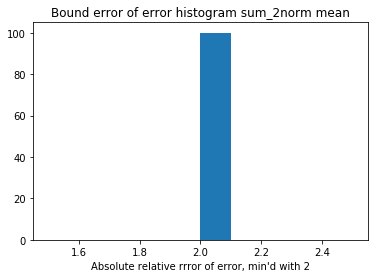

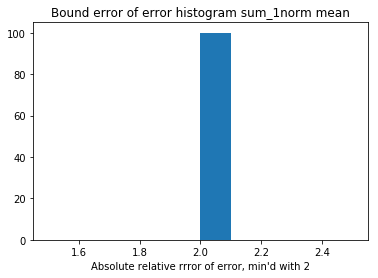

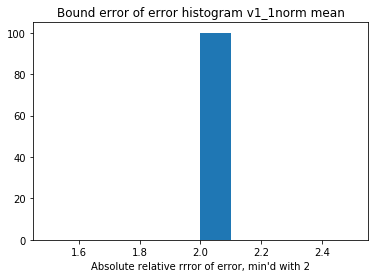

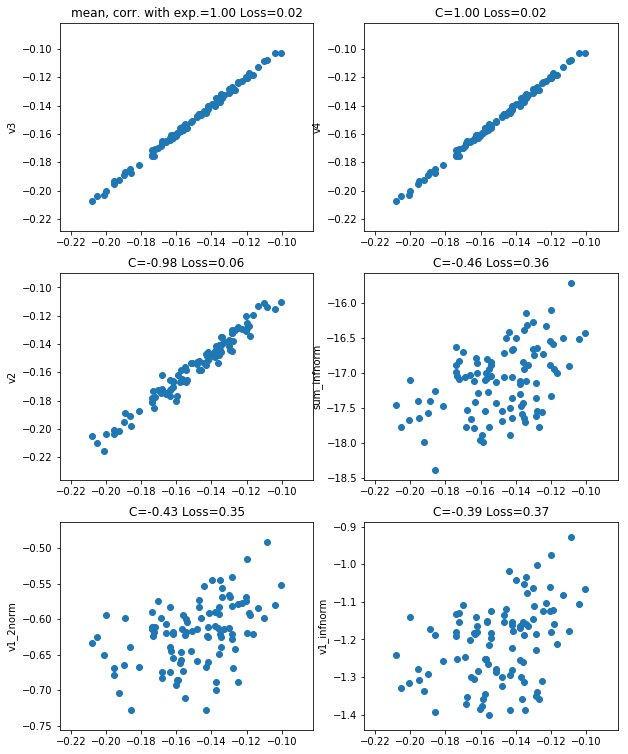

,bound,corr,rank_loss
0,v3,0.998595,0.016364
1,v4,0.998595,0.016364
2,v2,-0.981440,0.059596
3,sum_infnorm,-0.457283,0.361616
4,v1_2norm,-0.432871,0.354343
5,v1_infnorm,-0.387018,0.373535
6,sum_fronorm,-0.331128,0.377374
7,sum_2norm,-0.278798,0.394545
8,sum_1norm,-0.059184,0.464848
9,v1_1norm,0.008004,0.473939


In [10]:
exp.process_scalar_output(exp.preprocess_scalar_input_scalar_output(results_mean), 'mean')

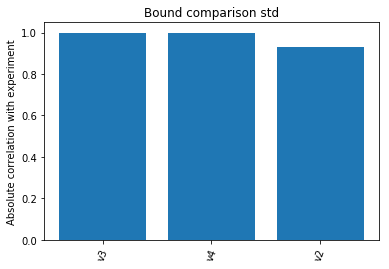

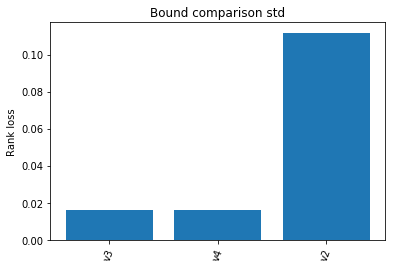

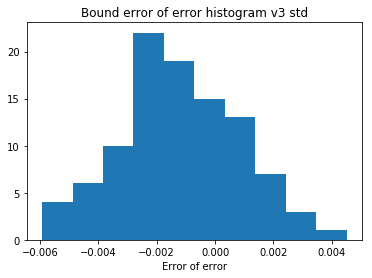

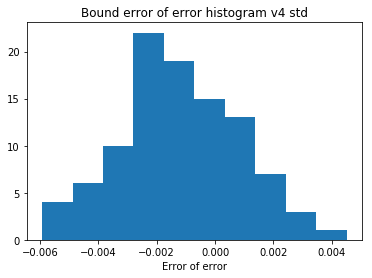

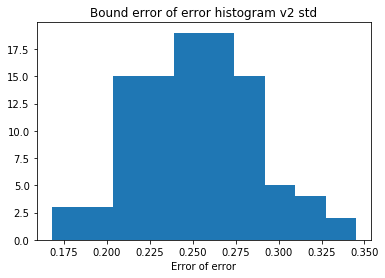

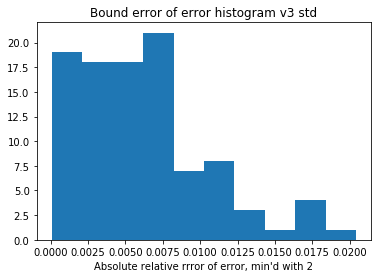

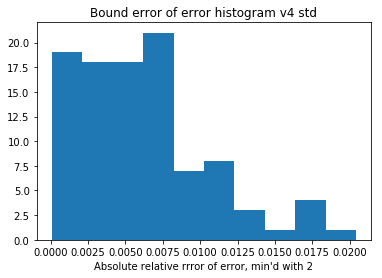

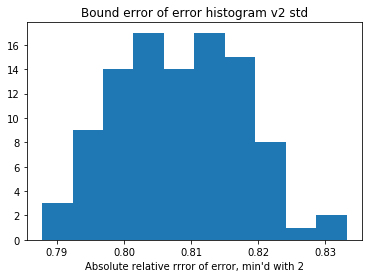

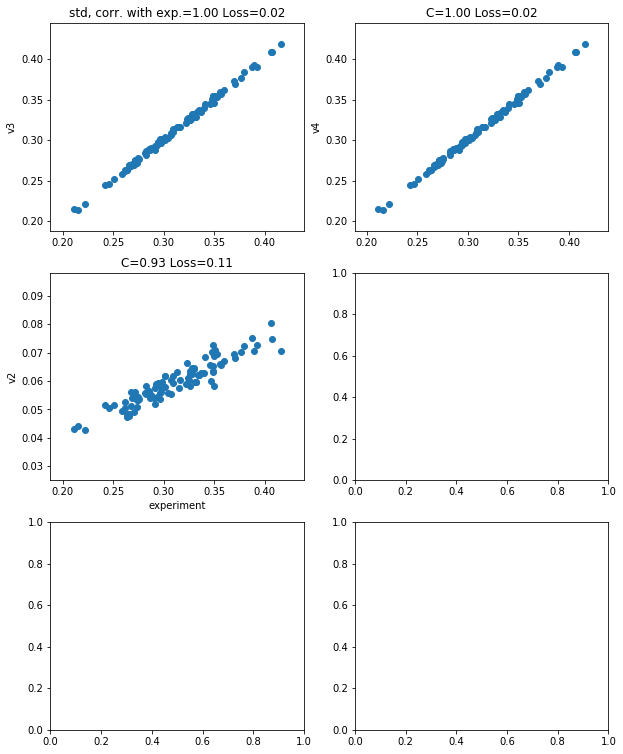

,bound,corr,rank_loss
0,v3,0.998823,0.016364
1,v4,0.998823,0.016364
2,v2,0.932150,0.111717


In [11]:
exp.process_scalar_output(exp.preprocess_scalar_input_scalar_output(results_std), 'std')